## Lab 4: Understanding sigmoid function with log likelihood

In this lab, we will investigate the effect of the coefficients in the sigmoid function, starting with one dimension. The quality of the fit is evaluated by the log likelihood function


### A few imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import Output,interact
from IPython.display import display
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib.widgets import Slider, Button, TextBox


### Help functions

In [2]:
def sigmoid(t,coefs,intercept):
    if t.ndim == 1:
        t = t.reshape(-1,1)
    return 1/(1+np.exp(-t @ coefs - intercept))

In [3]:
def log_likelihood(t,litho,coefs,intercept):
    prob_litho1 = sigmoid(t,coefs,intercept)
    sum_prob = np.log10(prob_litho1).T @ litho + np.log10(1-prob_litho1) @ (1-litho)
    n = t.shape[0]
    return -sum_prob/(2*n)


In [4]:
def threshold(coefs,intercept):
    return ((0.5 - intercept[0])/coefs[0])


### Fetching data

In [ ]:
# Fetch data

datapath = 'https://raw.githubusercontent.com/scienxlab/datasets/refs/heads/main/rpc/rpc-4-lithologies.csv' # Put your own path here
df = pd.read_csv(datapath)

In [6]:
# The data consist in samples from the rock property catalogs, compiled in https://agilescientific.com/blog/2015/10/5/the-rock-property-catalog-again, 
# compiled about Cretaceous shales in North America. In this subset, we have 4 different types of rocks and 3 parameters 
# (Rho = bulk density; vp = P-wave velocity and vs = S-wave velocity)

df.Lithology.unique()

array(['sandstone', 'shale', 'limestone', 'dolomite'], dtype=object)

In [7]:
df.columns

Index(['RPC', 'Description', 'Lithology', 'Vp', 'Vs', 'Rho'], dtype='object')

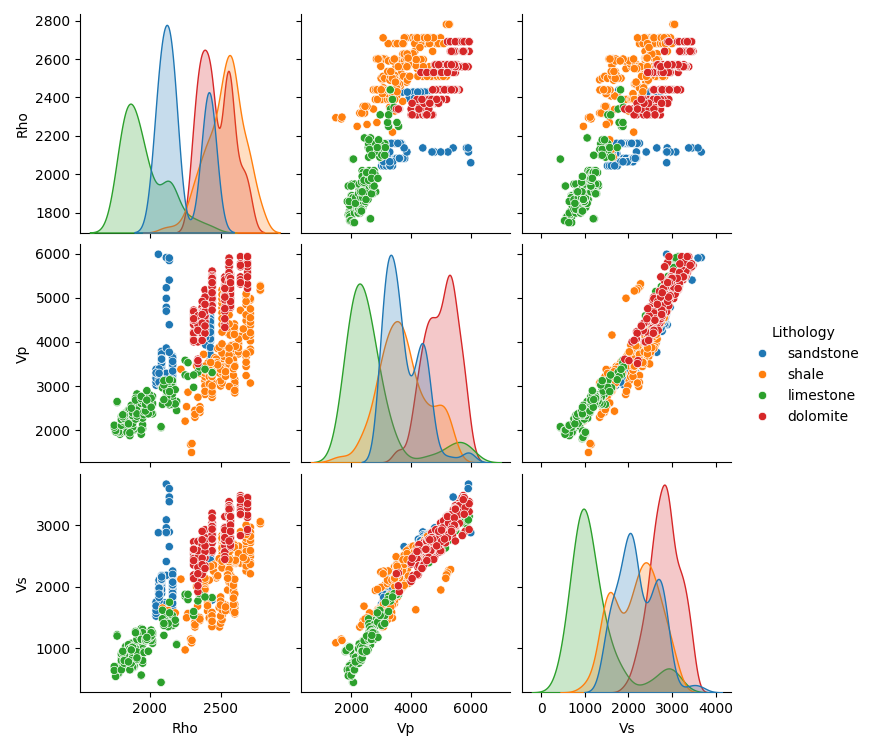

In [8]:
# Making a few plots to get to know the data:
# It looks like we could well discriminate data using a combination of 2 attributes. We'll start before that with one attribute

sns.pairplot(df,hue='Lithology',vars=['Rho','Vp','Vs'])

### Sigmoid with one variable

We start with one variable and try to understand the effect of the two parameters on the classification. 

Please feel free to update the feature selected (from Rho, Vp and Vs) in the cell below and of the 2 lithologies

In [9]:
### SELECT one attribute to work with and 2 lithologies

att_sel_1 = ['Rho']
litho_0 = 'limestone' 
litho_1 = 'dolomite'

In [10]:
### Extract data relevant for analysis 

work_df = df[att_sel_1 + ['Lithology']].copy()
work_df = work_df.query('Lithology ==@litho_0 | Lithology ==@litho_1')

# Then we encode the lithology to 0/1
work_df['Lithology']=work_df.Lithology.replace({litho_0:0,litho_1:1})

C:\Users\pniv\AppData\Local\Temp\ipykernel_43840\3609494577.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  work_df['Lithology']=work_df.Lithology.replace({litho_0:0,litho_1:1})


In [11]:
# So now here is our working data wiht a few stats

work_df.groupby('Lithology').describe()

Rho                                                           \
           count         mean         std     min     25%     50%     75%   
Lithology                                                                   
0          152.0  1961.447368  157.771769  1750.0  1830.0  1910.0  2082.5   
1          200.0  2470.650000  112.598712  2310.0  2370.0  2440.0  2560.0   

                   
              max  
Lithology          
0          2440.0  
1          2690.0

In [12]:
work_df.dropna(axis=0,how='any',inplace=True)

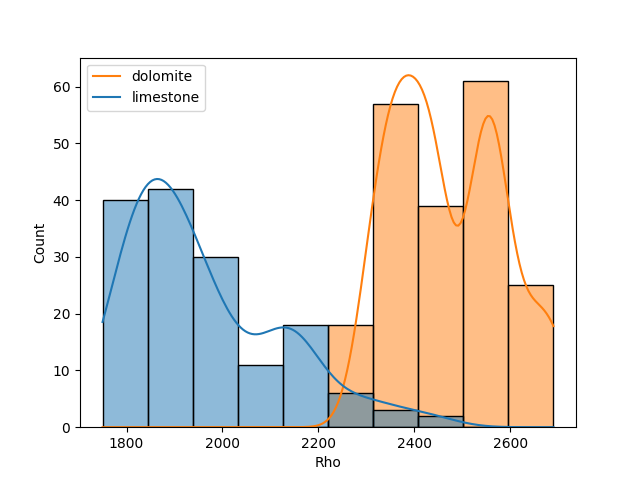

In [13]:
fig,ax = plt.subplots()
sns.histplot(work_df,x="Rho",hue='Lithology',kde=True)
ax.legend([litho_1,litho_0])


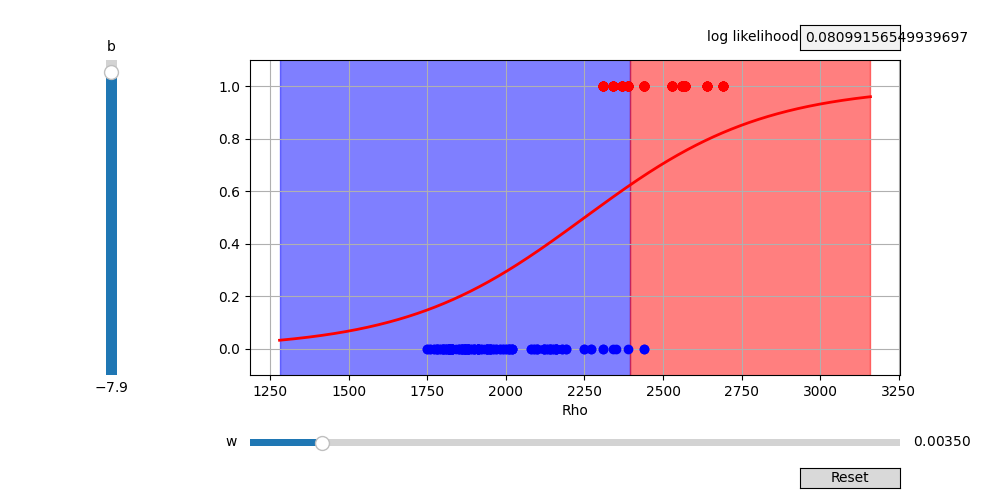

In [14]:
# The parametrized function to be plotted


xmin_1d = work_df[att_sel_1].min()-0.5*(work_df[att_sel_1].max()-work_df[att_sel_1].min())
xmax_1d = work_df[att_sel_1].max()+0.5*(work_df[att_sel_1].max()-work_df[att_sel_1].min())
xmin_1d=xmin_1d.values[0]
xmax_1d=xmax_1d.values[0]
x_1d = np.linspace(xmin_1d, xmax_1d, 1000)

# Define initial parameters
init_coefs_1d = 1 / work_df[att_sel_1].std().values
init_intercept_1d = - work_df[att_sel_1].mean().values[0] * init_coefs_1d

# Create the figure and the line that we will manipulate
fig1d, ax1d = plt.subplots(figsize=(10,5))
linesig1d, = ax1d.plot(x_1d,sigmoid(x_1d, init_coefs_1d,init_intercept_1d), color='r',lw=2)
points_1d, = ax1d.plot(work_df[work_df.Lithology==0][att_sel_1].values, work_df[work_df.Lithology==0]['Lithology'].values, 'bo')  # 'bo' means blue color, circle markers
points2_1d, = ax1d.plot(work_df[work_df.Lithology==1][att_sel_1].values, work_df[work_df.Lithology==1]['Lithology'].values, 'ro')  # 'ro' means red color, circle markers
init_cost1d = log_likelihood(work_df[att_sel_1].values,work_df['Lithology'].values,init_coefs_1d,init_intercept_1d)
blues1d = ax1d.axvspan(xmin_1d,threshold(init_coefs_1d,init_intercept_1d),-2,2,color='b',alpha=0.5)
reds1d = ax1d.axvspan(threshold(init_coefs_1d,init_intercept_1d),xmax_1d,-2,2,color='r',alpha=0.5)


ax1d.set_ylim((-0.1,1.1))
ax1d.set_xlabel(att_sel_1[0])

ax1d.grid()

# adjust the main plot to make room for the sliders
fig1d.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control w.
axcoef1d = fig1d.add_axes([0.25, 0.1, 0.65, 0.03])
coef_slider1d = Slider(
    ax=axcoef1d,
    label='w',
    valmin=0.5*init_coefs_1d[0],
    valmax=5*init_coefs_1d[0],
    valinit=init_coefs_1d[0],
)

# Make a vertically oriented slider to control the amplitude
axamp1d = fig1d.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider1d = Slider(
    ax=axamp1d,
    label="b",
    valmin=-200,
    valmax=0,
    valinit=init_intercept_1d[0],
    orientation="vertical"
)

# Make a vertically oriented slider to control the amplitude
axres1d = fig1d.add_axes([0.8, 0.9, 0.1, 0.05])
res_text_1d = TextBox(
    ax=axres1d,
    label="log likelihood",
    initial=init_cost1d,
)


# The function to be called anytime a slider's value changes
def update1(val):
    c_sl = np.array([coef_slider1d.val])
    i_sl = np.array([amp_slider1d.val])

    linesig1d.set_ydata(sigmoid(x_1d, c_sl,i_sl))
    blues1d.set_bounds((xmin_1d,-2,threshold(c_sl,i_sl)-xmin_1d,4))
    reds1d.set_bounds((threshold(c_sl,i_sl),-2,xmax_1d-threshold(c_sl,i_sl),4))
    cost1d = log_likelihood(work_df[att_sel_1].values,work_df['Lithology'].values, c_sl,i_sl)

    res_text_1d.set_val(cost1d)
    fig1d.canvas.draw_idle()


# register the update function with each slider
coef_slider1d.on_changed(update1)
amp_slider1d.on_changed(update1)
res_text_1d.on_text_change(update1)


# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax1d = fig1d.add_axes([0.8, 0.025, 0.1, 0.04])
button1d = Button(resetax1d, 'Reset', hovercolor='0.975')


def reset1(event):
    coef_slider1d.reset()
    amp_slider1d.reset()
    
button1d.on_clicked(reset1)

plt.show()


### Sigmoid with 2 variables

We repeat the exercise with 2 variables and 2 lithologies. This time, instead of visualizing the decision boundary, we visualize the sigmoid values

In [15]:
### SELECT one attribute to work with and 2 lithologies

att_sel_2 = ['Rho','Vp']
litho_0 = 'limestone' 
litho_1 = 'dolomite'

In [16]:
### Extract data relevant for analysis 

work_df = df[att_sel_2 + ['Lithology']].copy()
work_df = work_df.query('Lithology ==@litho_0 | Lithology ==@litho_1')

# Then we encode the lithology to 0/1
work_df['Lithology']=work_df.Lithology.replace({litho_0:0,litho_1:1})

C:\Users\pniv\AppData\Local\Temp\ipykernel_43840\1965728229.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  work_df['Lithology']=work_df.Lithology.replace({litho_0:0,litho_1:1})


In [17]:
# So now here is our working data wiht a few stats

work_df.groupby('Lithology').describe()

Rho                                                           \
           count         mean         std     min     25%     50%     75%   
Lithology                                                                   
0          152.0  1961.447368  157.771769  1750.0  1830.0  1910.0  2082.5   
1          200.0  2470.650000  112.598712  2310.0  2370.0  2440.0  2560.0   

                      Vp                                               \
              max  count        mean          std      min        25%   
Lithology                                                               
0          2440.0  200.0  2714.51965  1020.160926  1803.35  2074.7225   
1          2690.0  200.0  4990.32155   536.899342  3510.50  4593.1800   

                                        
               50%        75%      max  
Lithology                               
0          2384.19  2803.9725  5940.00  
1          5036.09  5380.5800  5938.32

In [18]:
work_df.dropna(axis=0,how='any',inplace=True)

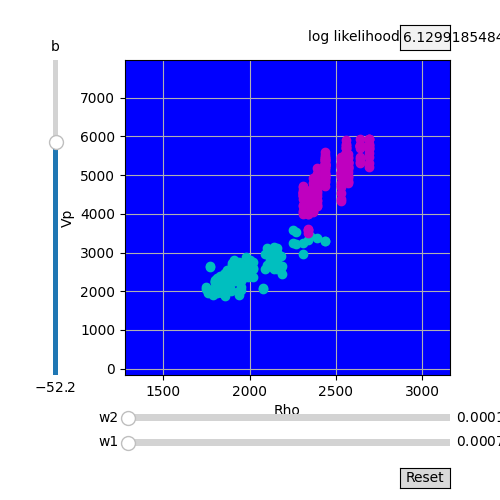

In [19]:




xmin = work_df[att_sel_2].min().values-0.5*(work_df[att_sel_2].max().values-work_df[att_sel_2].min().values)
xmax = work_df[att_sel_2].max().values+0.5*(work_df[att_sel_2].max().values-work_df[att_sel_2].min().values)

x = np.linspace(xmin[0], xmax[0], 1000)
y = np.linspace(xmin[1], xmax[1], 1000)
XY = np.meshgrid(x,y)
xy =np.vstack((XY[0].flatten(),XY[1].flatten())).T

# Define initial parameters
init_coefs = 0.2 / work_df[att_sel_2].std().values
init_intercept = - np.dot(work_df[att_sel_2].mean().values,init_coefs)-50
image_sig= sigmoid(xy,init_coefs,init_intercept)
init_cost = log_likelihood(work_df[att_sel_2].values,work_df['Lithology'].values,init_coefs,init_intercept)

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(figsize=(5,5))


points, = ax.plot(work_df[work_df.Lithology==0][att_sel_2].values[:,0], work_df[work_df.Lithology==0][att_sel_2].values[:,1], 'co')  # 'bo' means blue color, circle markers
points2, = ax.plot(work_df[work_df.Lithology==1][att_sel_2].values[:,0], work_df[work_df.Lithology==1][att_sel_2].values[:,1], 'mo')  # 'ro' means red color, circle markers
raster = ax.pcolormesh(x,y,image_sig.reshape(1000,1000),vmin=0.,vmax=1,cmap='bwr')


ax.set_xlabel(att_sel_2[0])
ax.set_ylabel(att_sel_2[1])

ax.grid()

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control w1.
axcoef0 = fig.add_axes([0.25, 0.1, 0.65, 0.03])
coef_slider0 = Slider(
    ax=axcoef0,
    label='w1',
    valmin=0.5*init_coefs[0],
    valmax=50*init_coefs[0],
    valinit=init_coefs[0],
)

# Make a horizontal slider to control w2.
axcoef1 = fig.add_axes([0.25, 0.15, 0.65, 0.03])
coef_slider1 = Slider(
    ax=axcoef1,
    label='w2',
    valmin=0.5*init_coefs[1],
    valmax=50*init_coefs[1],
    valinit=init_coefs[1],
)

# # Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="b",
    valmin=-200,
    valmax=0,
    valinit=init_intercept,
    orientation="vertical"
)

# Make a vertically oriented slider to control the amplitude
axres = fig.add_axes([0.8, 0.9, 0.1, 0.05])
res_text = TextBox(
    ax=axres,
    label="log likelihood",
    initial=init_cost,
)

# The function to be called anytime a slider's value changes
def update(val):
    image_sig= sigmoid(xy,[coef_slider0.val,coef_slider1.val],amp_slider.val)
    raster.set_array(image_sig.reshape(1000,1000))
    cost = log_likelihood(work_df[att_sel_2].values,work_df['Lithology'].values,[coef_slider0.val,coef_slider1.val],amp_slider.val)

    res_text.set_val(cost)

    fig.canvas.draw_idle()


# register the update function with each slider
coef_slider0.on_changed(update)
coef_slider1.on_changed(update)
amp_slider.on_changed(update)
res_text.on_text_change(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    coef_slider0.reset()
    coef_slider1.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

# Congratulations ! 
you understand now why logistic regression really works better on classification problems than linear regression. 